In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pprint import pprint

from utils import merge_kernel_time, get_fc_flops

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
pd.set_option('display.max_rows', 80)
%matplotlib inline

In [3]:
path = "../data/linear/merged_kernel_times.csv"
df = pd.read_csv(path)

In [4]:
df.head()

,Params,Inputs,Bias,Input Size,Output Size,Context,Stream,Device,CC,Avg. Active Threads Per Warp,...,Theoretical Active Warps per SM (warp),Theoretical Occupancy (%),Threads (thread),Warp Cycles Per Executed Instruction (cycle),Warp Cycles Per Issued Instruction (cycle),Latency (ms),kFLOPs,Duration (usecond),Kernels Launched,Precision
0,1.161.0.1.1,1.0,0.0,1.0,1.0,1.0,7.0,0.0,8.0,14.22,...,12.0,18.75,128.0,20.52,17.92,0.109056,0.003,4.51,1.0,161
1,1.161.0.1.120,1.0,0.0,1.0,120.0,1.0,7.0,0.0,8.0,30.27,...,64.0,100.00,1024.0,31.65,26.20,0.109568,0.360,3.84,1.0,161
2,1.161.0.1.20,1.0,0.0,1.0,20.0,1.0,7.0,0.0,8.0,25.28,...,64.0,100.00,256.0,35.77,29.62,0.109056,0.060,3.78,1.0,161
3,1.161.0.1.240,1.0,0.0,1.0,240.0,1.0,7.0,0.0,8.0,30.28,...,64.0,100.00,2048.0,34.27,28.37,0.107008,0.720,3.81,1.0,161
4,1.161.0.1.4,1.0,0.0,1.0,4.0,1.0,7.0,0.0,8.0,17.36,...,64.0,100.00,256.0,35.53,29.43,0.108032,0.012,3.81,1.0,161


In [5]:
categorical = ["Precision"]
numeric = list(sorted(["Inputs", "Bias", "Input Size", "Output Size", "kFLOPs", "Kernels Launched"])) # TODO: Kernels Launched not available

X_cols = list(sorted(categorical + numeric))
y_cols = ['Latency (ms)', 'Duration (usecond)']

X, y = df[X_cols], df[y_cols]
new_df = pd.concat([X, y], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)

# train_df.info()

array([[<AxesSubplot:title={'center':'Bias'}>,
        <AxesSubplot:title={'center':'Input Size'}>,
        <AxesSubplot:title={'center':'Inputs'}>],
       [<AxesSubplot:title={'center':'Kernels Launched'}>,
        <AxesSubplot:title={'center':'Output Size'}>,
        <AxesSubplot:title={'center':'Precision'}>],
       [<AxesSubplot:title={'center':'kFLOPs'}>,
        <AxesSubplot:title={'center':'Latency (ms)'}>,
        <AxesSubplot:title={'center':'Duration (usecond)'}>]],
      dtype=object)

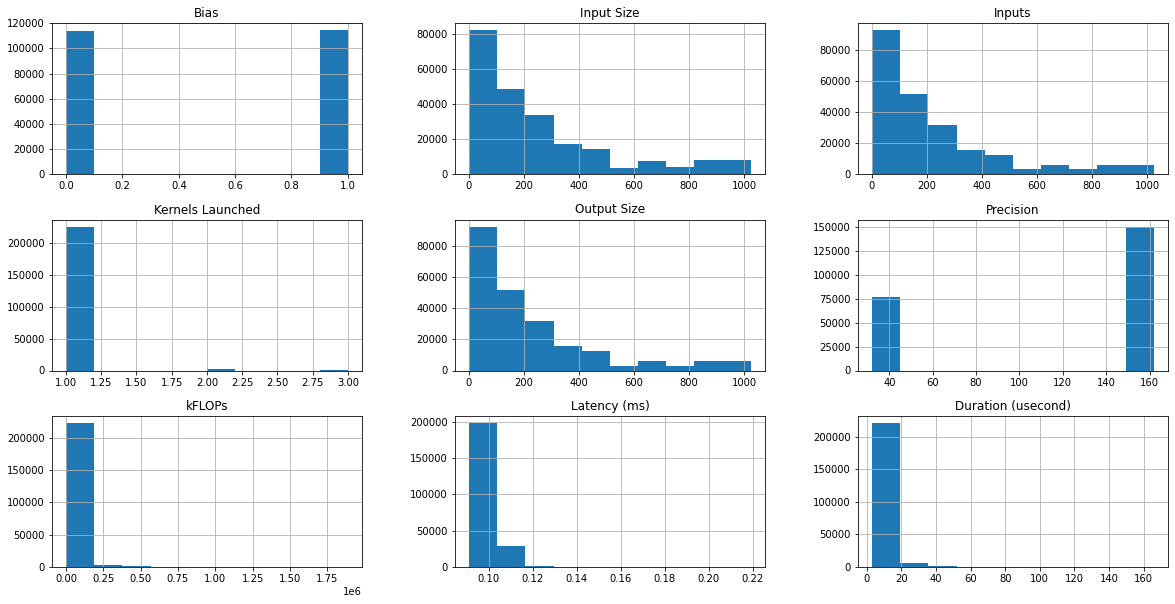

In [6]:
new_df.hist(figsize=(20, 10))

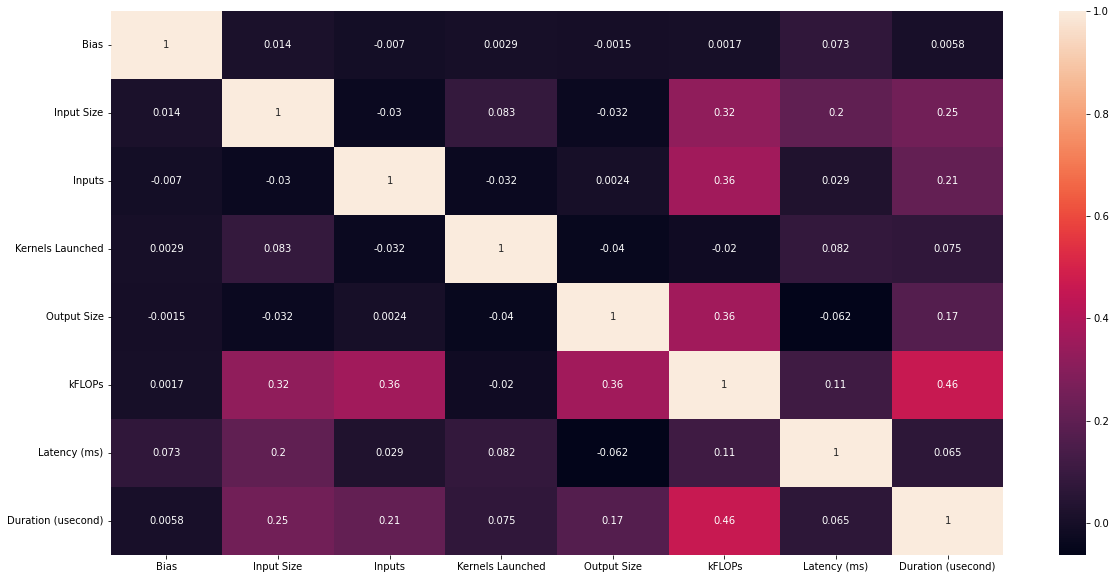

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(new_df[numeric + y_cols].corr(), annot=True)
plt.show()

In [8]:
def plot_scatter(df: pd.DataFrame, y: str):
    for col in df:
        if col != y:
            plt.figure(figsize=(6, 4))
            sns.scatterplot(x=df[col], y=df[y])
            plt.show()

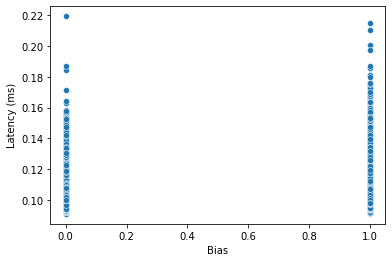

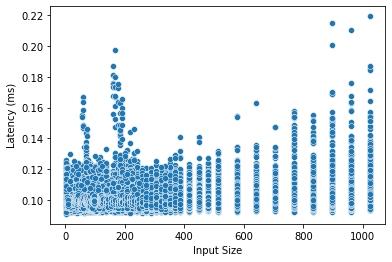

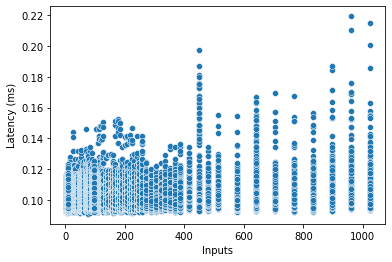

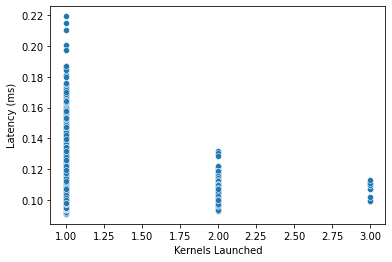

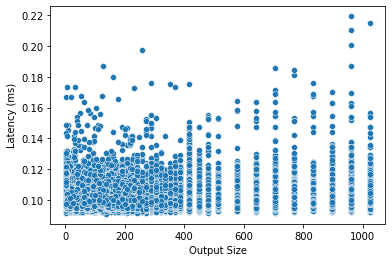

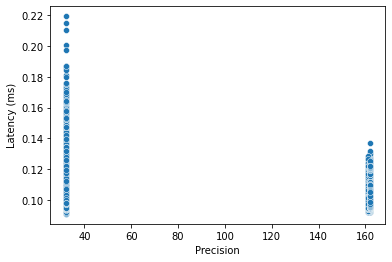

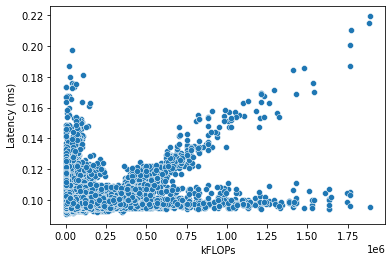

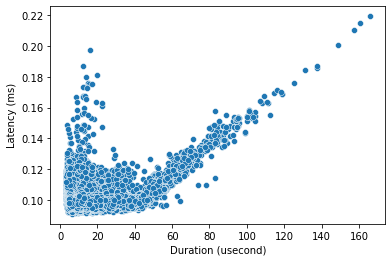

In [9]:
plot_scatter(new_df, "Latency (ms)")

In [10]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227889 entries, 0 to 227888
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Bias                227889 non-null  float64
 1   Input Size          227889 non-null  float64
 2   Inputs              227889 non-null  float64
 3   Kernels Launched    227889 non-null  float64
 4   Output Size         227889 non-null  float64
 5   Precision           227889 non-null  int64  
 6   kFLOPs              227889 non-null  float64
 7   Latency (ms)        227889 non-null  float64
 8   Duration (usecond)  227889 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 15.6 MB


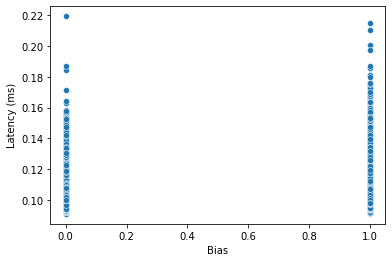

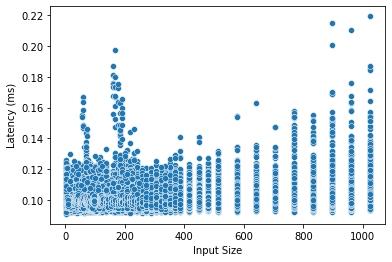

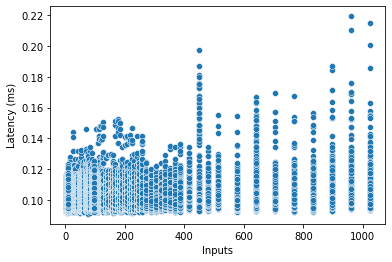

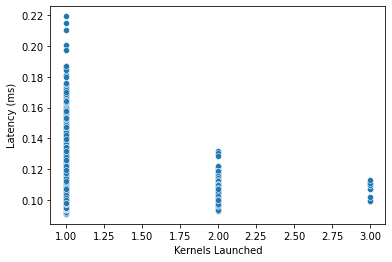

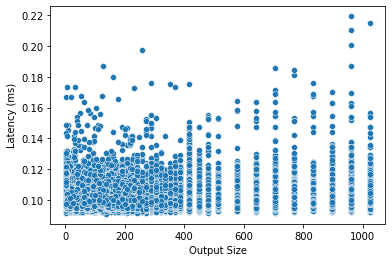

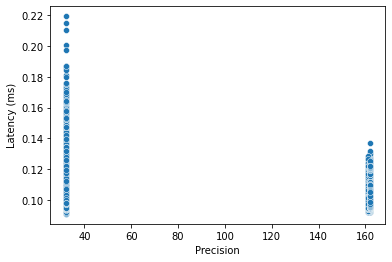

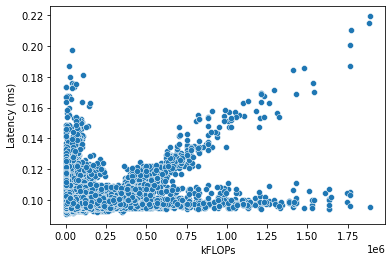

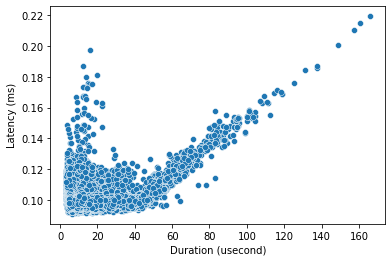

In [11]:
plot_scatter(new_df, "Latency (ms)")

In [16]:
out_df = new_df[(new_df['kFLOPs'] < 0.25e6) & (new_df['Latency (ms)'] > 0.1)]

In [17]:
out_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83505 entries, 0 to 227884
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Bias                83505 non-null  float64
 1   Input Size          83505 non-null  float64
 2   Inputs              83505 non-null  float64
 3   Kernels Launched    83505 non-null  float64
 4   Output Size         83505 non-null  float64
 5   Precision           83505 non-null  int64  
 6   kFLOPs              83505 non-null  float64
 7   Latency (ms)        83505 non-null  float64
 8   Duration (usecond)  83505 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 6.4 MB


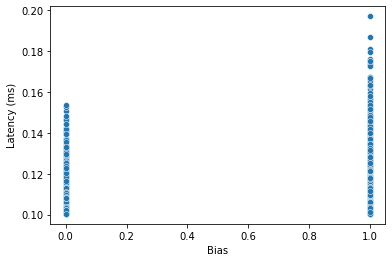

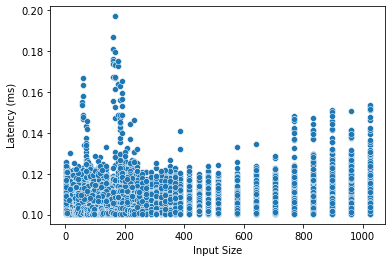

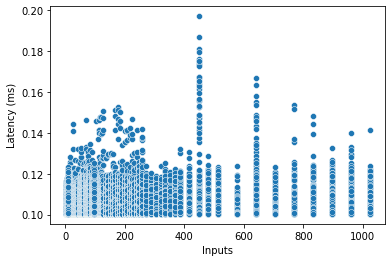

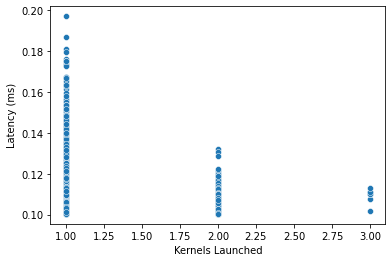

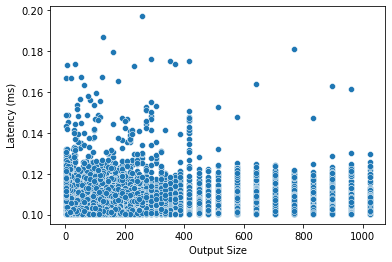

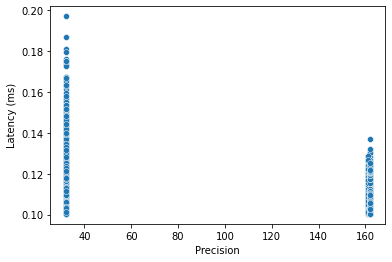

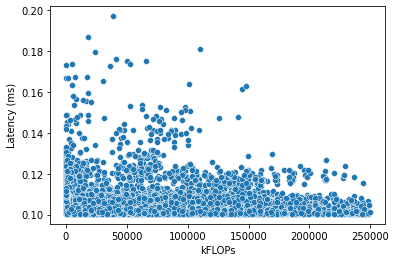

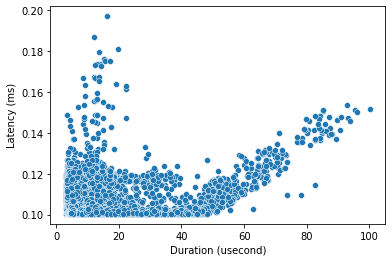

In [18]:
plot_scatter(out_df, 'Latency (ms)')

array([[<AxesSubplot:title={'center':'Bias'}>,
        <AxesSubplot:title={'center':'Input Size'}>,
        <AxesSubplot:title={'center':'Inputs'}>],
       [<AxesSubplot:title={'center':'Kernels Launched'}>,
        <AxesSubplot:title={'center':'Output Size'}>,
        <AxesSubplot:title={'center':'Precision'}>],
       [<AxesSubplot:title={'center':'kFLOPs'}>,
        <AxesSubplot:title={'center':'Latency (ms)'}>,
        <AxesSubplot:title={'center':'Duration (usecond)'}>]],
      dtype=object)

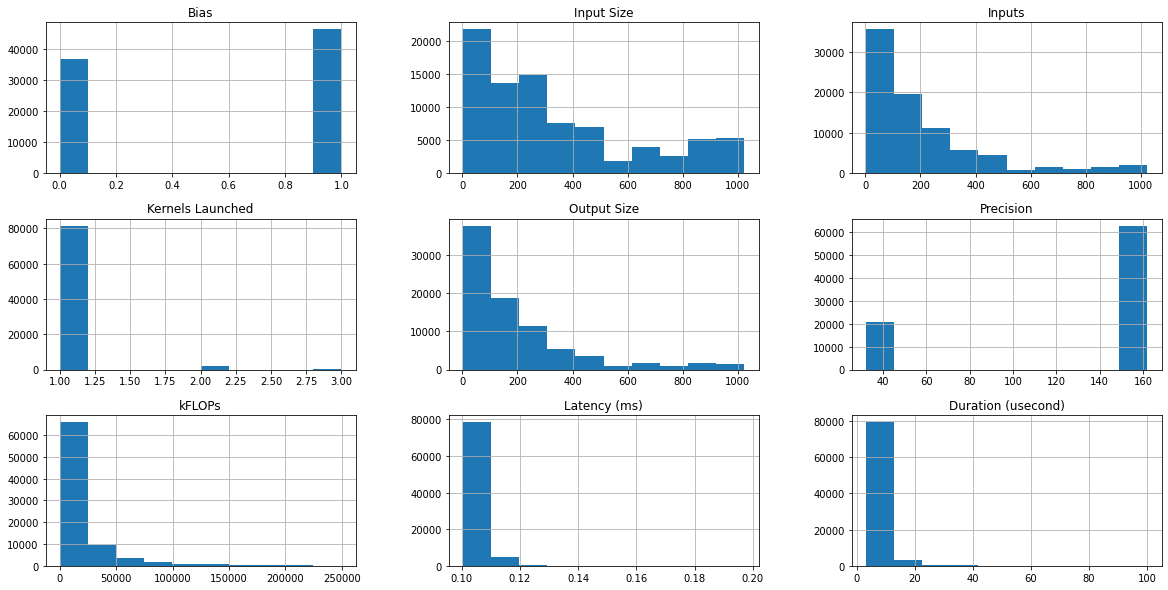

In [19]:
out_df.hist(figsize=(20, 10))